# Box versus Wheel - SSD-MobileNetV2
- by Marcelo Rovai @Set24

In [71]:
import tflite_runtime.interpreter as tflite
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import time

print("NumPy:", np.__version__)
print("Pillow:", Image.__version__)

NumPy: 1.23.2
Pillow: 10.4.0


In [2]:
ls models

coco_labels.txt
ei-raspi-object-detection-SSD_int8-model.lite
ei-raspi-object-detection-SSD-MobileNetv2-320x0320-int8.lite
lite-model_efficientdet_lite0_detection_metadata_1.tflite
ssd-mobilenet-v1-tflite-default-v1.tflite


In [4]:
# Try to create a TFLite Interpreter
model_path = "./models/ei-raspi-object-detection-SSD-MobileNetv2-320x0320-int8.lite"
interpreter = tflite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()
print("TFLite Interpreter created successfully!")

TFLite Interpreter created successfully!


In [5]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [6]:
input_details

[{'name': 'serving_default_input:0',
  'index': 0,
  'shape': array([  1, 320, 320,   3], dtype=int32),
  'shape_signature': array([  1, 320, 320,   3], dtype=int32),
  'dtype': numpy.int8,
  'quantization': (0.003921568859368563, -128),
  'quantization_parameters': {'scales': array([0.00392157], dtype=float32),
   'zero_points': array([-128], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [7]:
output_details

[{'name': 'StatefulPartitionedCall:1',
  'index': 378,
  'shape': array([ 1, 10], dtype=int32),
  'shape_signature': array([ 1, 10], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}},
 {'name': 'StatefulPartitionedCall:3',
  'index': 376,
  'shape': array([ 1, 10,  4], dtype=int32),
  'shape_signature': array([ 1, 10,  4], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}},
 {'name': 'StatefulPartitionedCall:0',
  'index': 379,
  'shape': array([1], dtype=int32),
  'shape_signature': array([1], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32

In [68]:
ls ./images/

beagles.jpg  box_2_wheel_1.jpg  cat_dog.jpeg     man_cat_dog.jpg
beatch.jpg   box_2_wheel_2.jpg  cats_dogs.jpg    office.jpeg
box_1.jpg    box_3_wheel_4.jpg  home-office.jpg  ship_2.jpg


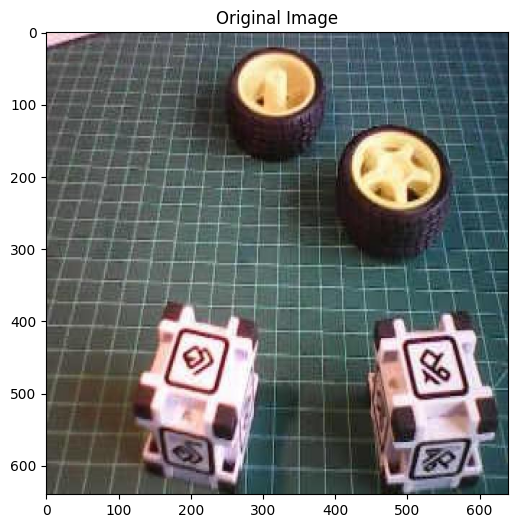

In [165]:
# Load he image
img_path = "./images/box_2_wheel_2.jpg"
orig_img = Image.open(img_path)

# Display the image
plt.figure(figsize=(6, 6))
plt.imshow(orig_img)
plt.title("Original Image")
plt.show()

In [166]:
scale, zero_point = input_details[0]['quantization']
img = orig_img.resize((input_details[0]['shape'][1], 
                  input_details[0]['shape'][2]))
img_array = np.array(img, dtype=np.float32) / 255.0
img_array = (img_array / scale + zero_point).clip(-128, 127).astype(np.int8)
input_data = np.expand_dims(img_array, axis=0)

In [167]:
input_data.shape, input_data.dtype

((1, 320, 320, 3), dtype('int8'))

In [168]:
# Inference on Raspi-Zero
start_time = time.time()
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
end_time = time.time()
inference_time = (end_time - start_time) * 1000  # Convert to milliseconds
print ("Inference time: {:.1f}ms".format(inference_time))

Inference time: 1311.9ms


In [169]:
interpreter.get_tensor(output_details[0]['index'])[0]

array([0.86328125, 0.86328125, 0.7734375 , 0.6484375 , 0.3515625 ,
       0.3515625 , 0.3515625 , 0.3515625 , 0.3515625 , 0.3515625 ],
      dtype=float32)

In [170]:
interpreter.get_tensor(output_details[1]['index'])[0]

array([[ 0.01461247,  0.38439587,  0.2793928 ,  0.62159896],
       [ 0.19234724,  0.6176628 ,  0.5012042 ,  0.888332  ],
       [ 0.5792029 ,  0.19102246,  0.9971932 ,  0.47538966],
       [ 0.5792029 ,  0.68904555,  0.9971932 ,  0.97973716],
       [ 0.04030751,  0.40373152,  0.21268989,  0.59615505],
       [ 0.8326583 ,  0.24165505,  0.96433866,  0.3635478 ],
       [ 0.9106695 ,  0.35563374,  0.9945335 ,  0.4259653 ],
       [ 0.01726595, -0.03286304,  0.27628556,  0.28286308],
       [ 0.61167145,  0.15337327,  0.9471272 ,  0.36701658],
       [ 0.64877874,  0.6557712 ,  0.96281224,  0.8602193 ]],
      dtype=float32)

In [171]:
interpreter.get_tensor(output_details[2]['index'])[0]

10.0

In [172]:
interpreter.get_tensor(output_details[3]['index'])[0]

array([1., 1., 0., 0., 1., 1., 0., 1., 0., 0.], dtype=float32)

In [173]:
boxes = interpreter.get_tensor(output_details[1]['index'])[0]  
classes = interpreter.get_tensor(output_details[3]['index'])[0]  
scores = interpreter.get_tensor(output_details[0]['index'])[0]        
num_detections = int(interpreter.get_tensor(output_details[2]['index'])[0])

In [174]:
# Post-process the results
for i in range(num_detections):
    if scores[i] > 0.5:  # Confidence threshold
        print(f"Object {i}:")
        print(f"  Bounding Box: {boxes[i]}")
        print(f"  Confidence: {scores[i]}")
        print(f"  Class: {classes[i]}")

Object 0:
  Bounding Box: [0.01461247 0.38439587 0.2793928  0.62159896]
  Confidence: 0.86328125
  Class: 1.0
Object 1:
  Bounding Box: [0.19234724 0.6176628  0.5012042  0.888332  ]
  Confidence: 0.86328125
  Class: 1.0
Object 2:
  Bounding Box: [0.5792029  0.19102246 0.9971932  0.47538966]
  Confidence: 0.7734375
  Class: 0.0
Object 3:
  Bounding Box: [0.5792029  0.68904555 0.9971932  0.97973716]
  Confidence: 0.6484375
  Class: 0.0


In [175]:
# Define labels 
labels = ['box', 'wheel'] 

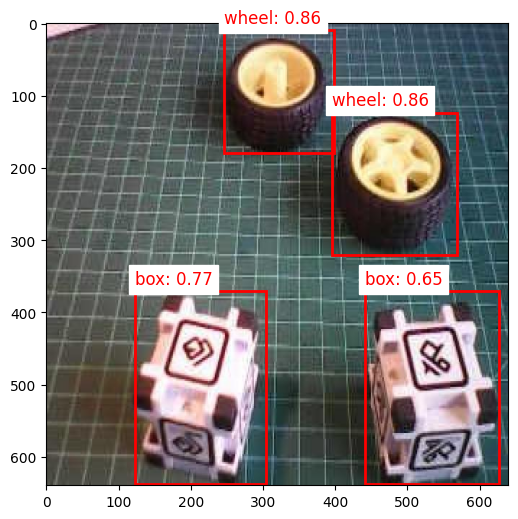

In [176]:
# Visualize the results
plt.figure(figsize=(6,6))
plt.imshow(orig_img)
for i in range(num_detections):
    if scores[i] > 0.5:  # Adjust threshold as needed
        ymin, xmin, ymax, xmax = boxes[i]
        (left, right, top, bottom) = (xmin * orig_img.width, xmax * orig_img.width, 
                                      ymin * orig_img.height, ymax * orig_img.height)
        rect = plt.Rectangle((left, top), right-left, bottom-top, 
                             fill=False, color='red', linewidth=2)
        plt.gca().add_patch(rect)
        class_id = int(classes[i])
        class_name = labels[class_id]
        plt.text(left, top-10, f'{class_name}: {scores[i]:.2f}', 
                 color='red', fontsize=12, backgroundcolor='white')

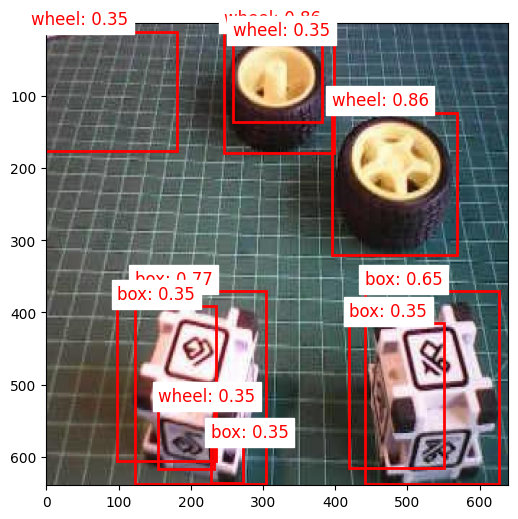

In [177]:
# Visualize the results
plt.figure(figsize=(6,6))
plt.imshow(orig_img)
for i in range(num_detections):
    if scores[i] > 0.3:  # Adjust threshold as needed
        ymin, xmin, ymax, xmax = boxes[i]
        (left, right, top, bottom) = (xmin * orig_img.width, xmax * orig_img.width, 
                                      ymin * orig_img.height, ymax * orig_img.height)
        rect = plt.Rectangle((left, top), right-left, bottom-top, 
                             fill=False, color='red', linewidth=2)
        plt.gca().add_patch(rect)
        class_id = int(classes[i])
        class_name = labels[class_id]
        plt.text(left, top-10, f'{class_name}: {scores[i]:.2f}', 
                 color='red', fontsize=12, backgroundcolor='white')

In [178]:
def detect_objects(img_path, conf=0.5):
    orig_img = Image.open(img_path)
    scale, zero_point = input_details[0]['quantization']
    img = orig_img.resize((input_details[0]['shape'][1], 
                      input_details[0]['shape'][2]))
    img_array = np.array(img, dtype=np.float32) / 255.0
    img_array = (img_array / scale + zero_point).clip(-128, 127).astype(np.int8)
    input_data = np.expand_dims(img_array, axis=0)
    
    # Inference on Raspi-Zero
    start_time = time.time()
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    end_time = time.time()
    inference_time = (end_time - start_time) * 1000  # Convert to milliseconds
    print ("Inference time: {:.1f}ms".format(inference_time))
    
    # Extract the outputs
    boxes = interpreter.get_tensor(output_details[1]['index'])[0]  
    classes = interpreter.get_tensor(output_details[3]['index'])[0]  
    scores = interpreter.get_tensor(output_details[0]['index'])[0]        
    num_detections = int(interpreter.get_tensor(output_details[2]['index'])[0])
    
    # Visualize the results
    plt.figure(figsize=(12, 8))
    plt.imshow(orig_img)
    for i in range(num_detections):
        if scores[i] > conf:  # Adjust threshold as needed
            ymin, xmin, ymax, xmax = boxes[i]
            (left, right, top, bottom) = (xmin * orig_img.width, xmax * orig_img.width, 
                                          ymin * orig_img.height, ymax * orig_img.height)
            rect = plt.Rectangle((left, top), right-left, bottom-top, 
                                 fill=False, color='red', linewidth=2)
            plt.gca().add_patch(rect)
            class_id = int(classes[i])
            class_name = labels[class_id]
            plt.text(left, top-10, f'{class_name}: {scores[i]:.2f}', 
                     color='red', fontsize=12, backgroundcolor='white')

Inference time: 831.2ms


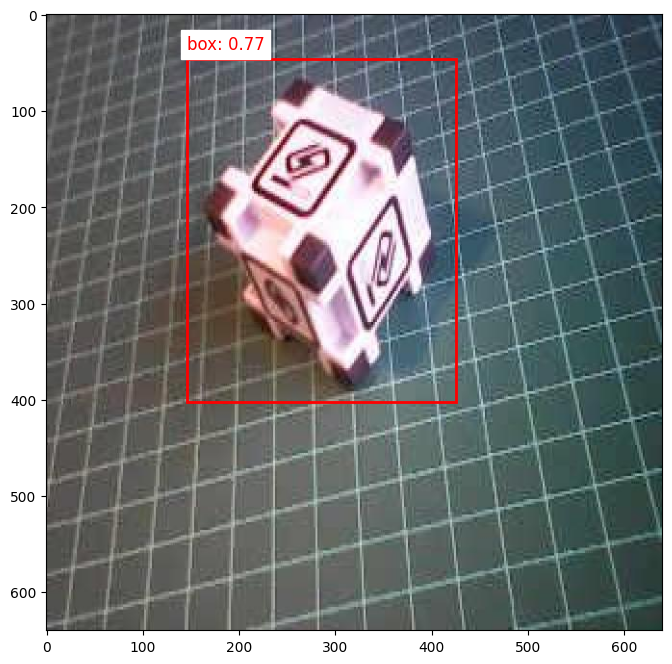

In [179]:
img_path = "./images/box_1.jpg"
detect_objects(img_path, conf=0.5)

Inference time: 584.1ms


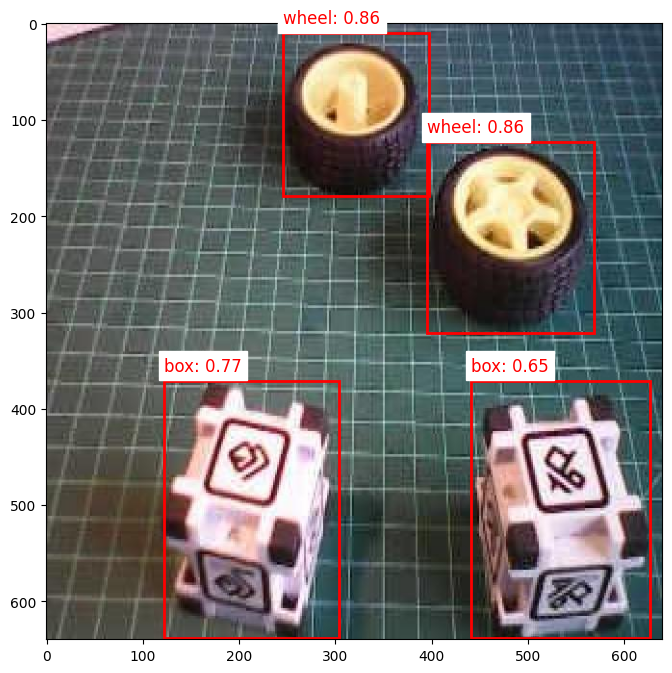

In [180]:
img_path = "./images/box_2_wheel_2.jpg"
detect_objects(img_path, conf=0.5)

Inference time: 582.1ms


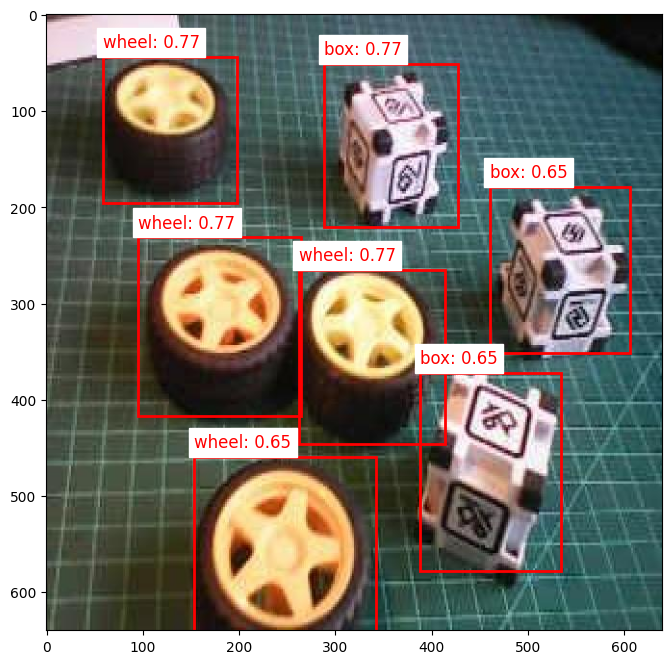

In [181]:
img_path = "./images/box_3_wheel_4.jpg"
detect_objects(img_path, conf=0.5)

Inference time: 587.3ms


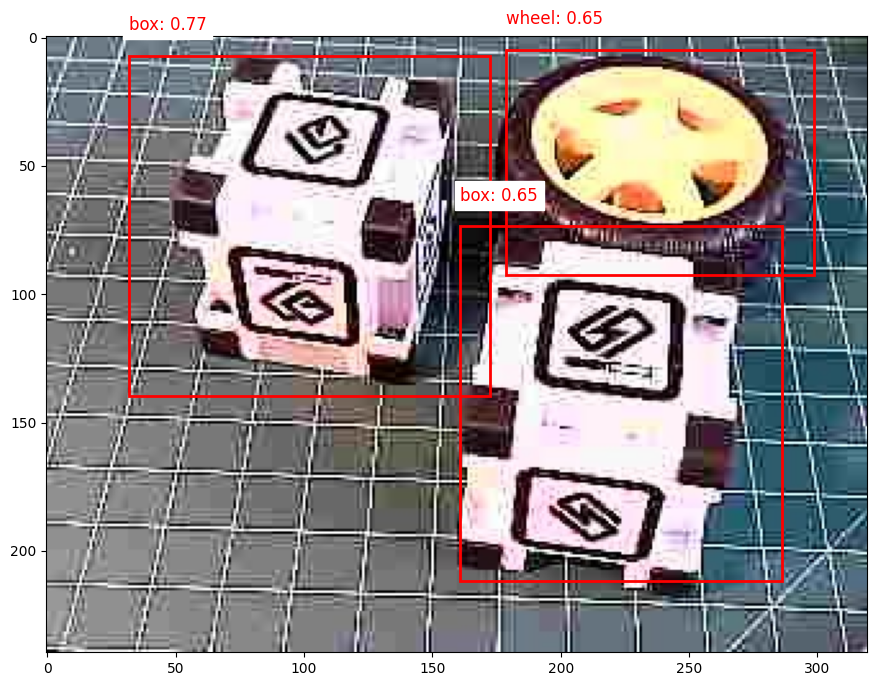

In [182]:
img_path = "./images/box_2_wheel_1.jpg"
detect_objects(img_path, conf=0.5)

Inference time: 582.7ms


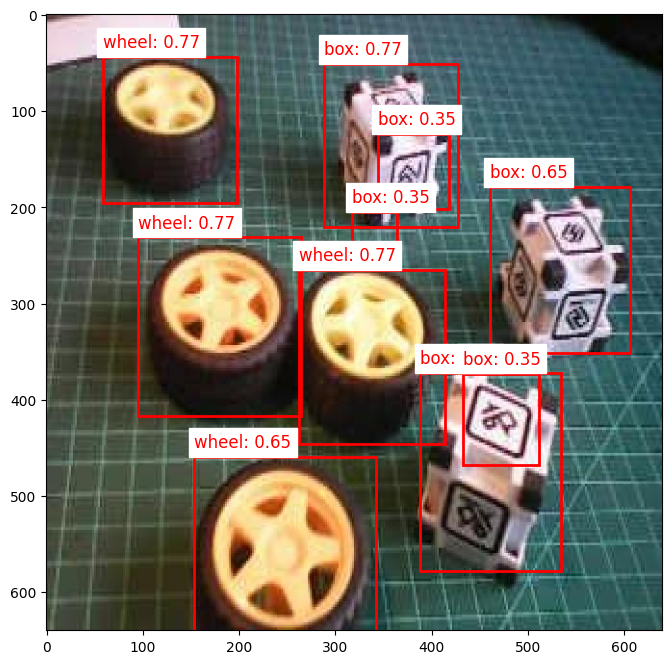

In [183]:
img_path = "./images/box_3_wheel_4.jpg"
detect_objects(img_path, conf=0.3)

In [184]:
def non_max_suppression(boxes, scores, threshold):
    # Convert to corner coordinates
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= threshold)[0]
        order = order[inds + 1]

    return keep

In [185]:
def visualize_detections(image, boxes, classes, scores, labels, threshold, iou_threshold):
    if isinstance(image, Image.Image):
        image_np = np.array(image)
    else:
        image_np = image

    height, width = image_np.shape[:2]
    
    # Convert normalized coordinates to pixel coordinates
    boxes_pixel = boxes * np.array([height, width, height, width])
    
    # Apply NMS
    keep = non_max_suppression(boxes_pixel, scores, iou_threshold)
    
    # Set the figure size to 12x8 inches
    fig, ax = plt.subplots(1, figsize=(6, 6))

    ax.imshow(image_np)
    
    for i in keep:
        if scores[i] > threshold:
            ymin, xmin, ymax, xmax = boxes[i]
            rect = patches.Rectangle((xmin * width, ymin * height),
                                     (xmax - xmin) * width,
                                     (ymax - ymin) * height,
                                     linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            class_name = labels[int(classes[i])]
            ax.text(xmin * width, ymin * height - 10,
                    f'{class_name}: {scores[i]:.2f}', color='red',
                    fontsize=12, backgroundcolor='white')

    plt.show()

In [186]:
def detect_objects(img_path, conf=0.5, iou=0.5):
    orig_img = Image.open(img_path)
    scale, zero_point = input_details[0]['quantization']
    img = orig_img.resize((input_details[0]['shape'][1], 
                      input_details[0]['shape'][2]))
    img_array = np.array(img, dtype=np.float32) / 255.0
    img_array = (img_array / scale + zero_point).clip(-128, 127).astype(np.int8)
    input_data = np.expand_dims(img_array, axis=0)
    
    # Inference on Raspi-Zero
    start_time = time.time()
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    end_time = time.time()
    inference_time = (end_time - start_time) * 1000  # Convert to milliseconds
    print ("Inference time: {:.1f}ms".format(inference_time))
    
    # Extract the outputs
    boxes = interpreter.get_tensor(output_details[1]['index'])[0]  
    classes = interpreter.get_tensor(output_details[3]['index'])[0]  
    scores = interpreter.get_tensor(output_details[0]['index'])[0]        
    num_detections = int(interpreter.get_tensor(output_details[2]['index'])[0])

    visualize_detections(orig_img, boxes, classes, scores, labels, 
                         threshold=conf, 
                         iou_threshold=iou)
    

Inference time: 584.8ms


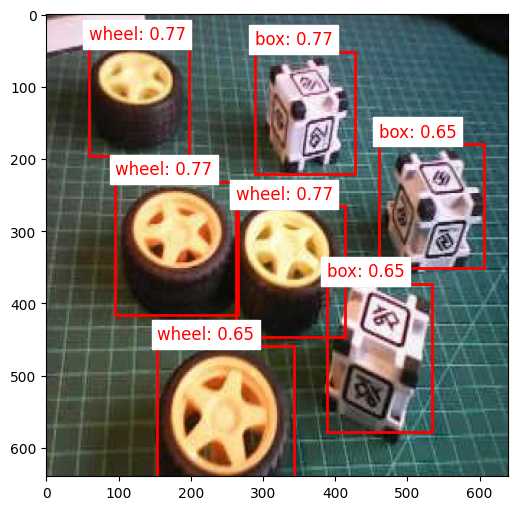

In [187]:
img_path = "./images/box_3_wheel_4.jpg"
detect_objects(img_path, conf=0.5,iou=0.5)

Inference time: 578.4ms


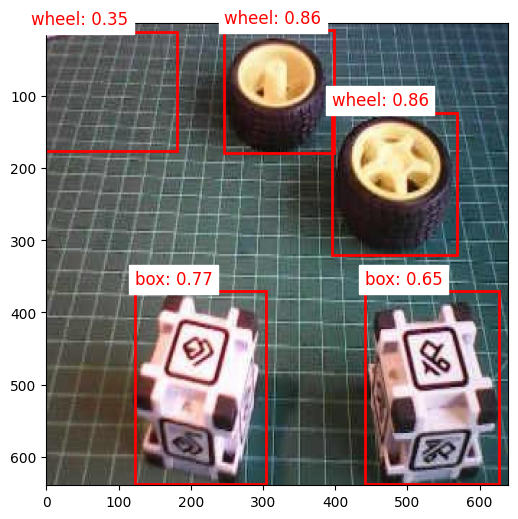

In [188]:
img_path = "./images/box_2_wheel_2.jpg"
detect_objects(img_path, conf=0.3,iou=0.05)

Inference time: 614.7ms


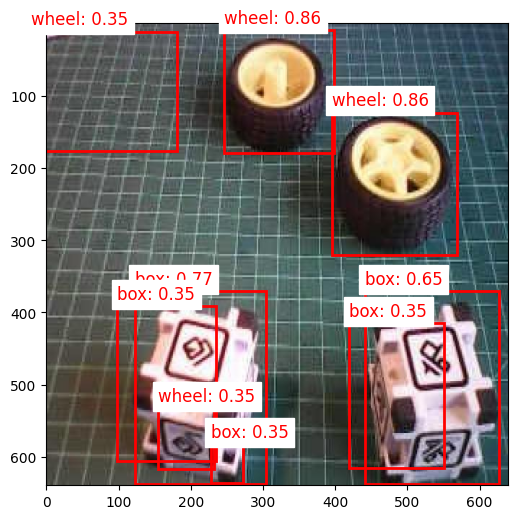

In [189]:
img_path = "./images/box_2_wheel_2.jpg"
detect_objects(img_path, conf=0.3)

Inference time: 637.1ms


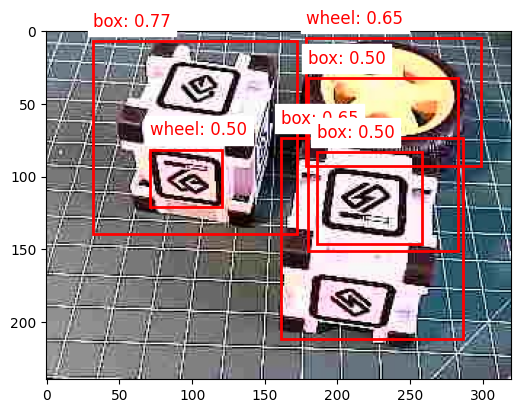

In [190]:
img_path = "./images/box_2_wheel_1.jpg"
detect_objects(img_path, conf=0.4,iou=0.5)

Inference time: 1031.5ms


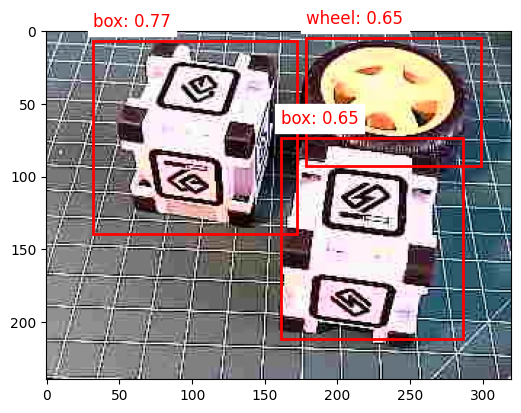

In [191]:
img_path = "./images/box_2_wheel_1.jpg"
detect_objects(img_path, conf=0.4,iou=0.1)